# Two layer perceptron 3.2

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, zero_one_loss

## Generating data

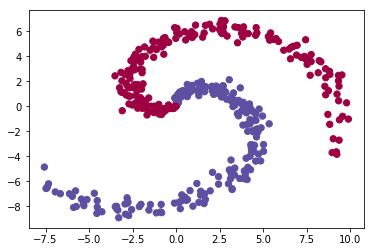

In [85]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes
X = np.zeros((N*K,D))# data matrix (each row = single example)

#Creates targets
y = np.ones(N,dtype=np.int)
minus = -1 * np.ones(N,dtype=np.int)
y = np.append(y,minus)

#Generates the samples
np.random.seed(42)
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,10,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    #y[ix] = j

#Splits data in train/test-sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

#Lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [86]:
len(y_test)

100

## General code for two layer perceptron

In [208]:
class neuralNet():
    def __init__(self,dim,nr1,nr2):
        self.nrOfInputs = dim 
        
        #Storing errors for each epoch to eventually plot a learning curve
        self.trainAbsErrors = []
        self.trainMseErrors = []
        self.testAbsErrors = []
        self.testMseErrors = []
        
        self.finalW = [] #Store weights when training is done
        self.shape_y = 0 #Nr of outputs, initially 0
        
        self.nrOfNodes_layer1 = nr1
        self.nrOfNodes_layer2 = nr2
    
    def initWeights(self,nrOfNeuronsInLayer,nrOfInputsPerNeuron):
        #Need to add one one weight for bias term
        np.random.seed(42)
        w = np.random.normal(0,1,size=(nrOfInputsPerNeuron+1,nrOfNeuronsInLayer))
        return w
    
    #Introduces non-linearity
    def transferFunc(self,x):
        transformed = 2/(1+np.exp(-x))-1
        return transformed

    def transferDerivative(self, x):
        derivative = np.multiply((1+x),(1-x))/2
        return derivative
    
    #Outputs activations in layer 1 for task 3.2.2
    def inspectActivation(self,patterns):
        w1 = self.finalW[0]
        w2 = self.finalW[1]
        hout,_ = self.forwardPass(patterns,w1,w2) 
        return hout[:,:3] #Exclude bias
        
    def predict(self,patterns):
        _,pred = self.forwardPass(patterns,self.finalW[0],self.finalW[1])
        pred[pred>=0]=int(1)
        pred[pred<0]=int(-1)
        return pred
    
    #Takes NxM-dimensional input, passes it throught the two layers and produces an output
    def forwardPass(self,patterns,w_1,w_2): 
        bias = np.ones(len(patterns),dtype=int)
        patterns = np.column_stack([patterns,bias])

        h_in = np.dot(patterns,w_1) #hin = w_1*[patterns + bias] (transposed)
        h_out = np.column_stack([self.transferFunc(h_in),bias]) #hout = [transferFunc(hin)+bias]  
        o_in = np.dot(h_out,w_2) #oin = w_2 * hout (transposed)
        o_out = self.transferFunc(o_in) #out = transferFunc(oin)
        
        return h_out,o_out
    
    #Backpropagates the error, calculating how each weight contributes to it
    def backPropagation(self,targets,h_out,o_out,w_2):
        targets = targets.reshape(targets.shape[0],self.shape_y)        
        delta_o = np.multiply((o_out-targets),self.transferDerivative(o_out))    
        delta_h = np.dot(delta_o,w_2.T)*self.transferDerivative(h_out)
        delta_h = delta_h[:,:self.nrOfNodes_layer1]
        return delta_h,delta_o
     
    #Calculates the rate of zero-one-loss and MSE of the predictions
    def calcError(self,pred,y,epochNr,traintest):
        mse = mean_squared_error(y,pred)
        
        #Thresholding
        pred[pred>=0]=1
        pred[pred<0]=-1
        zOloss = zero_one_loss(y,pred,normalize=True)
        
        #print("Nr of errors in",traintest,"data during epoch",epochNr,":",zOloss)
        return zOloss,mse
        
    #Update weights according to specified learning rate (eta) and alpha
    def update_weights(self,X,y,w_1,w_2,dw_1,dw_2,delta_h,delta_o,h_out):
        bias = np.ones(len(X),dtype=int)
        #updateWeights
        alpha=0.9
        eta=0.05
        dw_1 = np.multiply(dw_1,alpha)-np.dot(np.column_stack([X,bias]).T,delta_h)*(1-alpha)            
        dw_2 = np.multiply(dw_2,alpha)-np.dot(h_out.T,delta_o)*(1-alpha)

        w_1 = w_1 + dw_1*eta
        w_2 = w_2 + dw_2*eta

        return w_1,w_2,dw_1,dw_2
    
    #Trains a neural network using batch learning
    def train_batch(self,X,y,X_test,y_test,epochs):
        self.shape_y = int(y.size/len(y))
        w_1 = self.initWeights(self.nrOfNodes_layer1,self.nrOfInputs) #Weights for first layer
        w_2 = self.initWeights(self.nrOfNodes_layer2,self.nrOfNodes_layer1) #Weights for second layer
        dw_1 = 0
        dw_2 = 0
        
        bias = np.ones(len(X),dtype=int)
        for epoch in range(epochs):
            h_out,o_out = self.forwardPass(X,w_1,w_2) #Forward pass            
            delta_h,delta_o = self.backPropagation(y,h_out,o_out,w_2) #backPropagation
            w_1,w_2,dw_1,dw_2 = self.update_weights(X,y,w_1,w_2,dw_1,dw_2,delta_h,delta_o,h_out) #Update weights
    
            #Make a prediction on training data with the current weights
            _,predictions_train = self.forwardPass(X,w_1,w_2)
            train_abs, train_mse = self.calcError(predictions_train,y,epoch,"train")

            #Make a prediction on testing data with the current weights
            _,predictions_test = self.forwardPass(X_test,w_1,w_2) #calc error on testdata as well
            test_abs, test_mse = self.calcError(predictions_test,y_test,epoch,"test")

            #Store errors
            self.trainAbsErrors.append(train_abs)
            self.trainMseErrors.append(train_mse)
            self.testAbsErrors.append(test_abs)
            self.testMseErrors.append(test_mse)
        
        #Store final weights for later use
        self.finalW = [w_1,w_2]

    #Trains a neural network using sequential learning.
    #Could be merged with train_batch() if one where to enable dynamic
    #batch size
    def train_seq(self,patterns,targets,X_test,y_test,epochs):
        self.shape_y = int(targets.size/len(targets))
        w_1 = self.initWeights(self.nrOfNodes_layer1,self.nrOfInputs) #Weights for first layer
        w_2 = self.initWeights(self.nrOfNodes_layer2,self.nrOfNodes_layer1) #Weights for second layer
        dw_1 = 0
        dw_2 = 0
        
        bias = np.ones(len(patterns),dtype=int)
        for epoch in range(epochs):
            for i in range(targets.size):
                X = patterns[i].reshape(1,2)                
                y = np.array(targets[i])
                
                h_out,o_out = self.forwardPass(X,w_1,w_2) #Forward pass            
                delta_h,delta_o = self.backPropagation(y,h_out,o_out,w_2) #backPropagation
                w_1,w_2,dw_1,dw_2 = self.update_weights(X,y,w_1,w_2,dw_1,dw_2,delta_h,delta_o,h_out)

            #Make a prediction on training data with the current weights
            _,predictions_train = self.forwardPass(patterns,w_1,w_2)            
            train_abs, train_mse = self.calcError(predictions_train,targets,epoch,"train")

            #Make a prediction on testing data with the current weights
            _,predictions_test = self.forwardPass(X_test,w_1,w_2) #calc error on testdata as well
            test_abs, test_mse = self.calcError(predictions_test,y_test,epoch,"test")
          
            self.testAbsErrors.append(test_abs)
            self.testMseErrors.append(test_mse)
            self.trainAbsErrors.append(train_abs)
            self.trainMseErrors.append(train_mse)
        
        self.finalW = [w_1,w_2]
    
    #Plots the 0/1-loss and MSE for each epoch
    def evaluate(self,epochs):
        f,axarr = plt.subplots(2,sharex=True)
        axarr[0].plot(range(epochs),self.trainAbsErrors, '-',label="train")
        axarr[0].plot(range(epochs),self.testAbsErrors, '-',label="test")
        axarr[0].set_title('Ratio of misclassifications')
        
        axarr[1].plot(range(epochs),self.trainMseErrors, '-',label="train")
        axarr[1].plot(range(epochs),self.testMseErrors, '-',label="test")
        axarr[1].set_title('Mean squared error')
        
        plt.grid()
        plt.legend()
        plt.show()
        
    #Prints out the errors from thes final training epoch    
    def printErrors(self):
        print("Final misclassification ratio:",self.testAbsErrors[len(self.testAbsErrors)-1])
        print("Final MSE:",self.testMseErrors[len(self.testMseErrors)-1])        

## Experiments for 3.2.1
### First we experiment with a 2-4-1 setting...

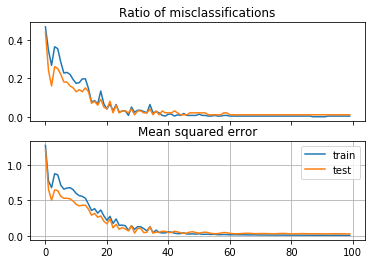

Final misclassification ratio: 0.01
Final MSE: 0.0312562516269


In [102]:
#BATCH LEARNING

nodesInFirstLayer=4
nodesInSecondLayer=1
nrOfInputs=2
epochs = 100

nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_batch(X_train,y_train,X_test,y_test,epochs)
nn.evaluate(epochs)
nn.printErrors()


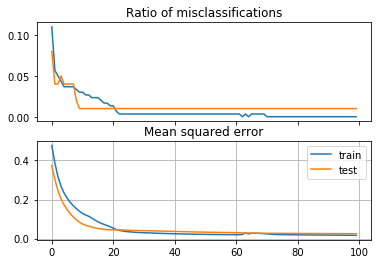

Final misclassification ratio: 0.01
Final MSE: 0.0251312629385


In [104]:
#SEQUENTIAL LEARNING

nodesInFirstLayer=4
nodesInSecondLayer=1
nrOfInputs=2
epochs = 100

nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_seq(X_train,y_train,X_test,y_test,epochs)
nn.evaluate(epochs)
nn.printErrors()

### Next we try a 2-16-1 set-up to see if there's any difference

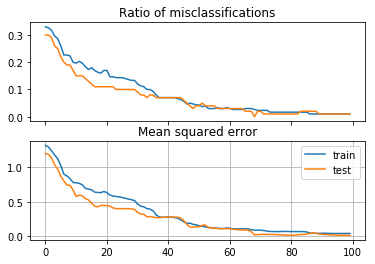

Final misclassification ratio: 0.01
Final MSE: 0.0172239005543


In [118]:
#BATCH LEARNING
nodesInFirstLayer=128
nodesInSecondLayer=1
epochs = 100
nrOfInputs=2

nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_batch(X_train,y_train,X_test,y_test,epochs)
nn.evaluate(epochs)
nn.printErrors()

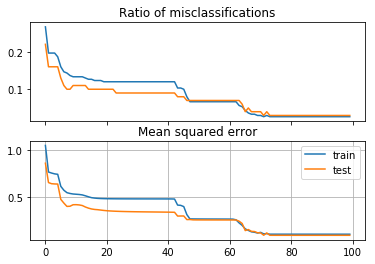

Final misclassification ratio: 0.03
Final MSE: 0.0986315091373


In [100]:
#SEQUENTIAL LEARNING

nodesInFirstLayer=128
nodesInSecondLayer=1
nrOfInputs=2
epochs = 100


nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_seq(X_train,y_train,X_test,y_test,epochs)
nn.evaluate(epochs)
nn.printErrors()

In [98]:
node_array1=[1,2,4,8,16,32,64,128]
nodesInSecondLayer=1
for node1 in node_array1:
    print("Nr of nodes in 1st layer:",node1)
    nn = neuralNet(2,node1,nodesInSecondLayer)
    nn.train_seq(X_train,y_train,X_test,y_test,100)
    nn.printErrors()
    nn=0
    print("\n")

Nr of nodes in 1st layer: 1
Final misclassification ratio: 0.19
Final MSE: 0.48926597118


Nr of nodes in 1st layer: 2
Final misclassification ratio: 0.07
Final MSE: 0.237013702648


Nr of nodes in 1st layer: 4
Final misclassification ratio: 0.01
Final MSE: 0.0251312629385


Nr of nodes in 1st layer: 8
Final misclassification ratio: 0.01
Final MSE: 0.0223314051177


Nr of nodes in 1st layer: 16
Final misclassification ratio: 0.01
Final MSE: 0.0209484109596


Nr of nodes in 1st layer: 32
Final misclassification ratio: 0.01
Final MSE: 0.0194945124858


Nr of nodes in 1st layer: 64
Final misclassification ratio: 0.01
Final MSE: 0.0182012591818


Nr of nodes in 1st layer: 128
Final misclassification ratio: 0.03
Final MSE: 0.0986315091373




## Experiments for 3.2.2
The encoding problem. Set up network with 8-3-8 structure

In [181]:
#Generates random 1x8 vectors for testing
def generateAutoData(nr):
    np.random.seed(42)
    X_auto = []
    for i in range(nr):
        index = np.random.randint(8)-1
        one8 = -1*np.ones(8, dtype=int)
        one8[index]=1
        X_auto.append(one8)
    return np.array(X_auto)

#Generates the 8-unique representations of a one-hot-encoded 1x8 vector
def genTrainData():
    X_train=[]
    for i in range(8):
        one8 = -1*np.ones(8, dtype=int)
        one8[i]=1
        X_train.append(one8)
    return np.array(X_train)
        
X_auto_train = genTrainData()
X_auto_test = generateAutoData(50)


In [209]:
#Some examples
print(X_auto_train[0])
print(X_auto_train[7])

[ 1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1  1]


In [188]:
#TRAIN AND TEST NETWORK WITH SAME DATA
nrOfInputs = 8
nodesInFirstLayer=3
nodesInSecondLayer=8
epochs = 750

nn_3 = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn_3.train_batch(X_auto_train,X_auto_train,X_auto_test,X_auto_test,epochs)

Final misclassification ratio: 0.0
Final MSE: 0.0600239162148


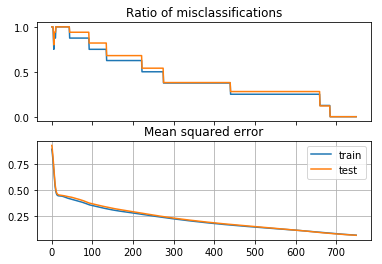

In [190]:
nn_3.printErrors()
nn_3.evaluate(epochs)

In [195]:
ind = range(33,43)
pred = nn_3.predict(X_auto[ind])
for i in ind:
    print("Sample:",X_auto[i])
    print("Predict:",pred[i-33],"\n")


Sample: [ 1 -1 -1 -1 -1 -1 -1 -1]
Predict: [ 1. -1. -1. -1. -1. -1. -1. -1.] 

Sample: [-1 -1 -1 -1  1 -1 -1 -1]
Predict: [-1. -1. -1. -1.  1. -1. -1. -1.] 

Sample: [-1 -1 -1  1 -1 -1 -1 -1]
Predict: [-1. -1. -1.  1. -1. -1. -1. -1.] 

Sample: [-1 -1  1 -1 -1 -1 -1 -1]
Predict: [-1. -1.  1. -1. -1. -1. -1. -1.] 

Sample: [-1 -1 -1 -1 -1 -1 -1  1]
Predict: [-1. -1. -1. -1. -1. -1. -1.  1.] 

Sample: [-1 -1 -1 -1 -1 -1 -1  1]
Predict: [-1. -1. -1. -1. -1. -1. -1.  1.] 

Sample: [-1  1 -1 -1 -1 -1 -1 -1]
Predict: [-1.  1. -1. -1. -1. -1. -1. -1.] 

Sample: [-1  1 -1 -1 -1 -1 -1 -1]
Predict: [-1.  1. -1. -1. -1. -1. -1. -1.] 

Sample: [-1 -1 -1 -1 -1  1 -1 -1]
Predict: [-1. -1. -1. -1. -1.  1. -1. -1.] 

Sample: [ 1 -1 -1 -1 -1 -1 -1 -1]
Predict: [ 1. -1. -1. -1. -1. -1. -1. -1.] 



1st layer Weights:
 [[-0.36615866  0.95126467  1.50701715]
 [ 2.14606898  0.32625851  1.26280609]
 [ 1.50883771  1.67264209 -1.08487314]
 [ 1.95613378 -0.6266048  -0.78497075]
 [-0.99953566  0.50497275 -1.26592545]
 [-0.90329576 -2.22846349 -0.79427928]
 [-0.8202609  -1.52567908  1.8980173 ]
 [-0.33192514 -0.75302399 -3.00681105]
 [-0.46146158 -0.33251977 -1.0880608 ]] 

Activation: [-0.97709248 -0.91467318 -0.20102464]
Activation: [ 0.18115318  0.98181908 -0.4576969 ]
Activation: [ 0.55837632  0.0464186  -0.19207579]
Activation: [-0.97709248 -0.91467318 -0.20102464]
Activation: [ 0.6752908   0.76130645  0.9520544 ]
Activation: [-0.97300996 -0.69243694  0.9863049 ]
Activation: [ 0.55837632  0.0464186  -0.19207579]
Activation: [ 0.55837632  0.0464186  -0.19207579]
Activation: [-0.97709248 -0.91467318 -0.20102464]
Activation: [-0.93437883  0.92524863  0.97030581]


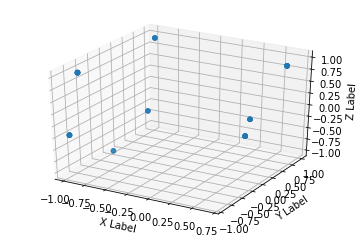

In [207]:
from mpl_toolkits.mplot3d import Axes3D

print("1st layer Weights:\n",nn_3.finalW[0],"\n")
activations = nn_3.inspectActivation(X_auto_test)
for i in range(10):
    print("Activation:",activations[i])

    
    
fig = plt.figure()
ax5 = fig.add_subplot(111,projection='3d')
#for c,m in [('r','o'),('b','^')]:
ax5.scatter(activations[:,0],activations[:,1],activations[:,2])
    
ax5.set_xlabel('X Label')
ax5.set_ylabel('Y Label')
ax5.set_zlabel('Z Label')
plt.show() 